In [1]:
%cd C:\Users\tanak\study\参考書\実践GAN\gans-in-action-master

C:\Users\tanak\study\参考書\実践GAN\gans-in-action-master


## 31. CycleGAN
画像から画像への翻訳(image-to-image translation)の1つであり、生成器(翻訳器)への入力は画像となる。  
例えば、以下のようなことに応用できる。
- 意味的なラベル(車の場所を青く、道であるべき場所を紫にしたもの)を、街路の写真にする
- 衛星画像をGoogle Mapsのようなビューにする
- 白黒画像をカラーにする
- 輪郭線からファッションアイテムを合成する

ただし、画像のペアが必要になり、対応する画像への直接的な対応が存在しないと意味のある結果はでない。  
つまり、全く同じだけれども、属するドメインだけが異なる対応画像が必要となる。  
  
#### サイクル一貫性損失
完全なペアを必要としないアイディアとしては、1つのドメインからもう1つのドメインに翻訳し、元に戻ってこられれば良いというものである。  
もし、同一のものにならなかったらCycleGANの最初の損失である**サイクル一貫性損失**を計算する。  
  
サイクル一貫性損失には、2つの生成器を使う。  
- AをBに翻訳する$G_{AB}$(簡単に$G$と呼ぶこともある)
- BをAに翻訳する$G_{BA}$(簡単に$F$と呼ぶこともある)

また、前進サイクル一貫性損失と後進サイクル一貫性損失の2つの損失があるが、  
これらが意味するのは$\hat{a}=F(G(a))\approx a$であり、$\hat{b}=G(F(b))\approx b$ということなので、  
1つずれているだけで本質的には同じものである。  
  
#### 敵対性損失
生成器$G_{AB}$による翻訳は、対応する識別器$D_B$を持ち、$G_{BA}$は、識別器$D_A$を持つ。    
Aへの翻訳によって生成される画像が本物に見えるかどうかについて常に$D_A$でテストするという考え方で、逆もまた同様である。
  
#### 同一性損失
CycleGANが画像の全般的な色構造(色温度)を保存するようにする。  
そこで、正規化のための項を導入して生成画像の色合いが元画僧と一貫したものになるようにする。  
画像に対する不要な変更にペナルティを課す。

#### CycleGANの構造
以下の2つの情報の流れがある。  
- ドメインAにある画像から始まるA-B-Aという流れ  
- ドメインBにある画像から始まるB-A-Bという流れ  

画像は2つのパスをたどる。  
1. 識別器に入れられて、本物かどうかの判断をするパス
2. (1)Bへと翻訳を行う生成器に入れられて、(2)識別器BによってドメインBの本物の画像に見えるかどうか評価
3. Aに再度翻訳されてサイクル損失ｗお計算するパス

#### 生成器
**U-Net**と呼ばれるエンコーダ。デコーダを持つ構造を利用している。  
- エンコーダ　各特徴マップの解像度を下げていく畳み込み層(圧縮パス:d0-d3)
- デコーダ　逆畳み込み層で画像を拡大して元のサイズに戻す(展開パス:u1-u4)

この構造には情報を効率よく伝達するための**スキップ接続**がある。  
d0-d3とu1-u4の接続されている。(d0-u4, d1-u3, d2-u2, d3-u1)

#### 識別器
識別器はPatchGAN構造に基づいている。

In [32]:
from __future__ import print_function, division
import scipy
from tensorflow.keras.datasets import mnist
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import datetime
import matplotlib.pyplot as plt
import sys
import numpy as np
import os
import warnings
warnings.simplefilter('ignore')

#### ネットワーク
1. 2つの識別器$D_A$、$D_B$を作成し、それらをコンパイルする
2. 2つの生成器を作る  
　a. $G_{AB}$と$G_{BA}$をインスタンス化する  
　b. 画像を入力できるように、双方向にplaceholderを作る  
　c. 両方を、別ドメインの画像へとリンクする  
　d. 再構築した画像が元のドメインに戻るようにplaceholderを作る  
　e. 双方向に同一性損失制約を計算する  
　f. 識別器のパラメータをいったん訓練対象から外す  
　g. 2つの生成器をコンパイルする  
  
#### 生成器
1. conv2d()関数を次のように定義する  
　a. 通常の2次元畳み込み層  
　b. Leaky ReLUによる活性化  
　c. インスタンスの正規化(Instance normalization)  
2. deconf2d()関数を転置畳み込み層として定義する  
　a. input_layerの解像度を上げる  
　b. ドロップアウト率が設定されていれば、その比率でドロップアウトを実行  
　c. InstanceNormalizationを常に実施する   
　d. 出力層とダウンサンプル部分の同次元の層を、スキップ接続する  
3. 入力(128×128×3)をとってきてd0に割り当てる  
4. これを畳み込み層d1に通して次の64×64×32の層を出力する  
5. d1をとってきて、conv2dを適用し、32×32×64のd2を得る  
6. d2をとってきて、conv2dを適用し、16×16×128のd3を得る  
7. d3をとってきて、conv2dを適用し、8×8×256のd4を得る  
8. u1: d4をアップサンプリングし、d3とu1の間にスキップ接続を作る  
9. u2: u1をアップサンプリングし、d2とu2の間にスキップ接続を作る  
10. u3: u2をアップサンプリングし、d1とu3の間にスキップ接続を作る  
11. u4: 通常のアップサンプリングを行い、128×128×64の画像に到達する
12. 通常の2D畳み込みを行い、不要な特徴マップを取り除き、128×128×3だけ得る  
  
#### 識別器
1. 入力画像(128×128×3)をとってきて、d1(64×64×64)に割り当てる  
2. d1(64×64×64)をとってきて、d2(32×32×128)に割り当てる  
3. d2(32×32×128)をとってきて、d3(16×16×256)に割り当てる  
4. d3(16×16×256)をとってきて、d4(8×8×512)に割り当てる  

In [40]:
class CycleGAN():
    def __init__(self):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        
        self.dataset_name = 'apple2orange'
        
        self.dataloader = DataLoader(dataset_name=self.dataset_name,
                                     img_res=(self.img_rows, self.img_cols))
        
        # Dの出力サイズ
        patch = int(self.img_rows / 2**4)
        self.disc_patch = (patch, patch, 1)
        
        # Gの最初のフィルタ数
        self.gf = 32
        # Dの最初のフィルタ数
        self.df = 64
        
        # 重みを小さくすると不要な変化が起こりやすくなる
        # サイクル一貫性損失の重み
        self.lambda_cycle = 10.0
        
        # 同一性損失の重み
        self.lambda_id = 0.9 * self.lambda_cycle
        
        optimizer = Adam(0.0002, 0.5)
        
        #---------------------
        # ネットワークの構築
        #---------------------
        self.d_A = self.build_discriminator()
        self.d_B = self.build_discriminator()
        self.d_A.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        self.d_B.compile(loss='mse',
                         optimizer=optimizer,
                         metrics=['accuracy'])
        
        # 生成器の計算グラフの構築
        self.g_AB = self.build_generator()
        self.g_BA = self.build_generator()
        
        imgs_A = Input(shape=self.img_shape)
        imgs_B = Input(shape=self.img_shape)
        
        fake_B = self.g_AB(imgs_A)
        fake_A = self.g_BA(imgs_B)
        
        reconstr_A = self.g_BA(fake_B)
        reconstr_B = self.g_AB(fake_A)
        
        # 画像の恒等写像
        imgs_A_id = self.g_BA(imgs_A)
        imgs_B_id = self.g_AB(imgs_B)
        
        self.d_A.trainable = False
        self.d_B.trainable = False
        
        valid_A = self.d_A(fake_A)
        valid_B = self.d_B(fake_B)
        
        self.combined = Model(inputs=[imgs_A, imgs_B],
                              outputs=[valid_A, valid_B,
                                       reconstr_A, reconstr_B,
                                       imgs_A_id, imgs_B_id])
        self.combined.compile(loss=['mse', 'mse',
                                    'mse', 'mse',
                                    'mse', 'mse'],
                             loss_weights = [1, 1,
                                             self.lambda_cycle,
                                             self.lambda_cycle,
                                             self.lambda_id,
                                             self.lambda_id],
                             optimizer=optimizer)
    
    @staticmethod
    def conv2d(layer_input, filters, f_size=4, normalization=True):
        d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
        d = LeakyReLU(alpha=0.2)(d)
        if normalization:
            d = InstanceNormalization()(d)
        return d
        
    @staticmethod
    def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
        u = UpSampling2D(size=2)(layer_input)
        u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
        if dropout_rate:
            u = Dropout(dropout_rate)(u)
        u = InstanceNormalization()(u)
        u = Concatenate()([u, skip_input])
        return u
    
    #---------------------
    # 生成器の構築
    #---------------------
    def build_generator(self):
        
        d0 = Input(shape=self.img_shape)
        
        d1 = self.conv2d(d0, self.gf)
        d2 = self.conv2d(d1, self.gf * 2)
        d3 = self.conv2d(d2, self.gf * 4)
        d4 = self.conv2d(d3, self.gf * 8)
        
        u1 = self.deconv2d(d4, d3, self.gf * 4)
        u2 = self.deconv2d(u1, d2, self.gf * 2)
        u3 = self.deconv2d(u2, d1, self.gf)
        
        u4 = UpSampling2D(size=2)(u3)
        output_img = Conv2D(self.channels, kernel_size=4,
                            strides=1, padding='same',
                            activation='tanh')(u4)
        return Model(d0, output_img)
    
    #---------------------
    # 識別器の構築
    #---------------------
    def build_discriminator(self):
        img = Input(shape=self.img_shape)

        d1 = self.conv2d(img, self.df, normalization=False)
        d2 = self.conv2d(d1, self.df * 2)
        d3 = self.conv2d(d2, self.df * 4)
        d4 = self.conv2d(d3, self.df * 8)

        validity = Conv2D(1, kernel_size=4, strides=1, padding='same')(d4)

        return Model(img, validity)
    
    def sample_images(self, epoch, batch_i):
        r, c = 2, 3

        imgs_A = self.dataloader.load_data(domain="A", batch_size=1, is_testing=True)
        imgs_B = self.dataloader.load_data(domain="B", batch_size=1, is_testing=True)
        
        # Translate images to the other domain
        fake_B = self.g_AB.predict(imgs_A)
        fake_A = self.g_BA.predict(imgs_B)
        # Translate back to original domain
        reconstr_A = self.g_BA.predict(fake_B)
        reconstr_B = self.g_AB.predict(fake_A)

        gen_imgs = np.concatenate([imgs_A, fake_B, reconstr_A, imgs_B, fake_A, reconstr_B])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        titles = ['Original', 'Translated', 'Reconstructed']
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i, j].set_title(titles[j])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%s/%d_%d.png" % (self.dataset_name, epoch, batch_i))
        plt.show()

#### 訓練
For　訓練の繰り返しごとに　do  
  
1. 識別器の訓練  
　a. 各ドメイン($imgs_A$と$imgs_B$)からランダムに画像を取り出してきて、ミニバッチを作る  
　b. 生成器$G_{AB}$を使い、$imgs_A$をドメインBに翻訳し、また$G_{BA}$を使い逆方向にも処理する  
　c. $D_A(imgs_A,1)$と$D_A(G_{BA}(imgs_A),0)$を計算してA内の本物画像と、Bから翻訳されてきた画像のそれぞれについての損失を得る。  
　　この2つの損失は足し合わせる。$D_A$の1と0はラベルとして用いる。  
　d. $D_B(imgs_B,1)$と$D_B(G_{AB}(imgs_B),0)$を計算してB内の本物画像と、Aから翻訳されてきた画像のそれぞれについての損失を得る。  
　　この2つの損失は足し合わせる。$D_B$の1と0はRavelとして用いる。  
　e. ステップcとdの損失を足し合わせて、識別器全体の損失とする  
2. 生成器の訓練  
　a. 複合モデルを使って  
　　- 画像集合をドメインAから($imgs_A$)とドメインBから($imgs_B$)入力する  
　　- 出力は:  
　　1. Aの妥当性:$D_A(G_{BA}(imgs_B))$  
　　2. Bの妥当性:$D_B(G_{AB}(imgs_A))$  
　　3. 再構築されたA:$G_{BA}(G_{AB}(imgs_A))$  
　　4. 再構築されたB:$G_{AB}(G_{BA}(imgs_B))$  
　　5. Aの恒等写像:$G_{BA}(imgs_A)$  
　　6. Bの恒等写像:$G_{AB}(imgs_B)$  
　b. サイクル一貫性損失、同一性損失、そして敵対性損失を使って両方の生成器パラメータを更新する。  
　　誤差関数は、  
　　- スカラー値(識別器の確率)に対しては平均二乗誤差(MSE)を用いる  
　　- 画像(再構成されたものや恒等写像されたもの)に対しては平均絶対誤差(MAE)を用いる  
  
End　for

In [43]:
class CycleGAN(CycleGAN):
    def train(self, epochs, batch_size=1, sample_interval=50):
        valid = np.ones((batch_size,) + self.disc_patch)
        fake = np.zeros((batch_size,) + self.disc_patch)
        
        for epoch in range(epochs):
            for batch_i, (imgs_A,imgs_B) in enumerate(self.dataloader.load_batch(batch_size)):
                #---------------------
                # 識別器の訓練
                #---------------------
                fake_B = self.g_AB.predict(imgs_A)
                fake_A = self.g_BA.predict(imgs_B)
                
                dA_loss_real = self.d_A.train_on_batch(imgs_A, valid)
                dA_loss_fake = self.d_A.train_on_batch(fake_A, fake)
                dA_loss = 0.5 * np.add(dA_loss_real, dA_loss_fake)
                
                dB_loss_real = self.d_B.train_on_batch(imgs_B, valid)
                dB_loss_fake = self.d_B.train_on_batch(fake_B, fake)
                dB_loss = 0.5 * np.add(dB_loss_real, dB_loss_fake)
                
                d_loss = 0.5 * np.add(dA_loss, dB_loss)
                
                #---------------------
                # 生成器の訓練
                #---------------------
                g_loss = self.combined.train_on_batch([imgs_A, imgs_B],
                                                      [valid, valid,
                                                       imgs_A, imgs_B,
                                                       imgs_A, imgs_B])
                if batch_i % sample_interval == 0:
                    self.sample_images(epoch, batch_i)

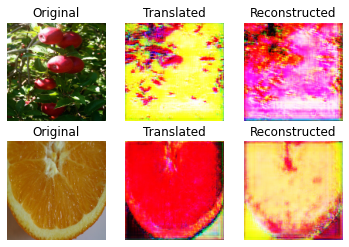

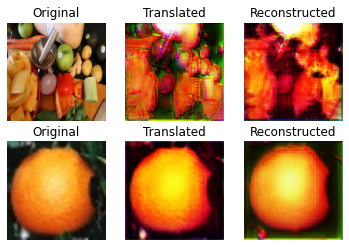

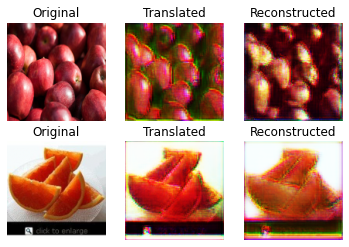

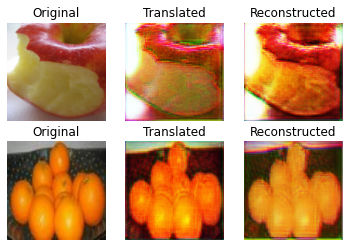

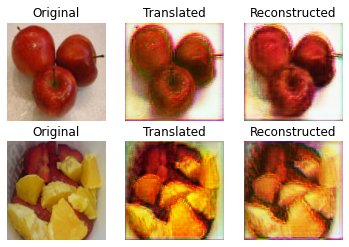

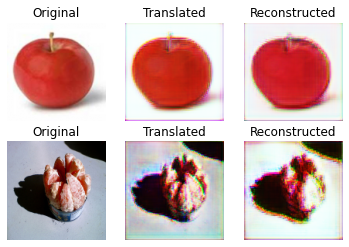

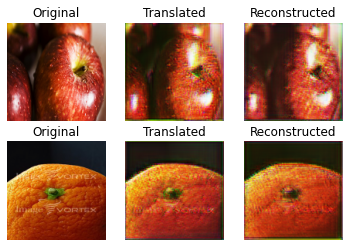

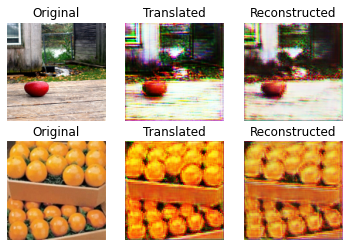

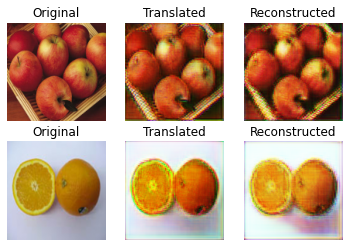

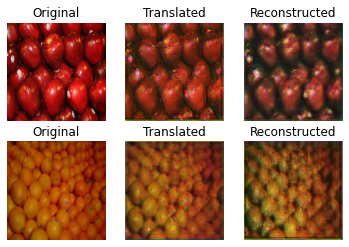

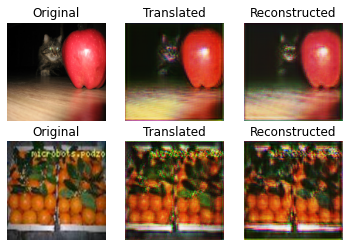

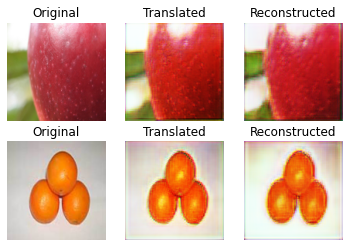

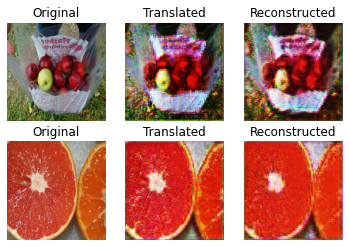

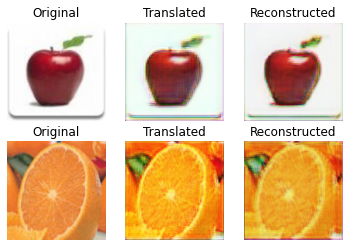

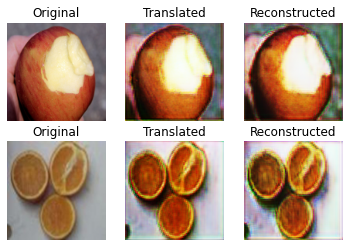

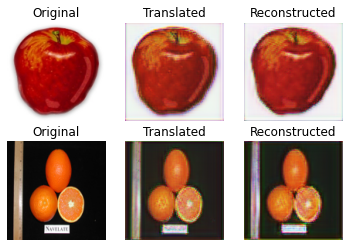

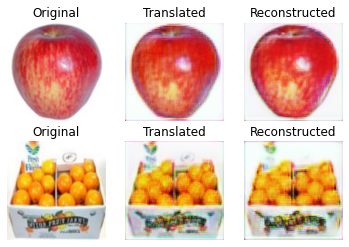

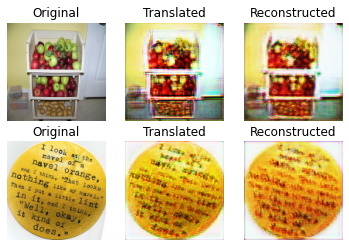

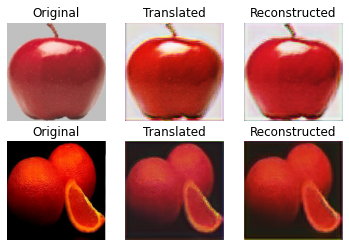

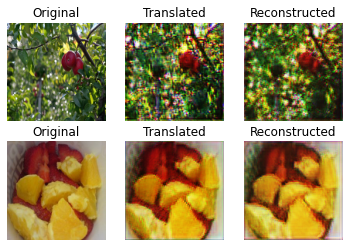

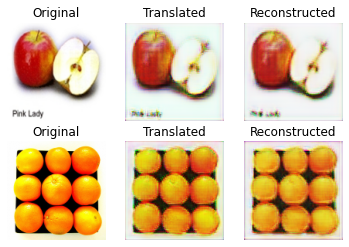

KeyboardInterrupt: 

In [44]:
cycle_gan = CycleGAN()
cycle_gan.train(epochs=100, batch_size=64, sample_interval=10)

In [ ]:
1

In [33]:
import scipy
import cv2
from imageio import imread
from glob import glob
import numpy as np

class DataLoader():
    def __init__(self, dataset_name, img_res=(128, 128, 3)):
        self.dataset_name = dataset_name
        self.img_res = img_res

    def load_data(self, domain, batch_size=1, is_testing=False):
        data_type = "train%s" % domain if not is_testing else "test%s" % domain
        path = glob('./datasets/%s/%s/*' % (self.dataset_name, data_type))

        batch_images = np.random.choice(path, size=batch_size)

        imgs = []
        for img_path in batch_images:
            img = self.imread(img_path)
            if not is_testing:
                #img = imresize(img, self.img_res)
                img = cv2.resize(img, self.img_res)

                if np.random.random() > 0.5:
                    img = np.fliplr(img)
            else:
                #img = imresize(img, self.img_res)
                img = cv2.resize(img, self.img_res)
            imgs.append(img)

        imgs = np.array(imgs)/127.5 - 1.

        return imgs

    def load_batch(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "val"
        path_A = glob('./datasets/%s/%sA/*' % (self.dataset_name, data_type))
        path_B = glob('./datasets/%s/%sB/*' % (self.dataset_name, data_type))

        self.n_batches = int(min(len(path_A), len(path_B)) / batch_size)
        total_samples = self.n_batches * batch_size

        # Sample n_batches * batch_size from each path list so that model sees all
        # samples from both domains
        path_A = np.random.choice(path_A, total_samples, replace=False)
        path_B = np.random.choice(path_B, total_samples, replace=False)

        for i in range(self.n_batches-1):
            batch_A = path_A[i*batch_size:(i+1)*batch_size]
            batch_B = path_B[i*batch_size:(i+1)*batch_size]
            imgs_A, imgs_B = [], []
            for img_A, img_B in zip(batch_A, batch_B):
                img_A = self.imread(img_A)
                img_B = self.imread(img_B)

                #img_A = imresize(img_A, self.img_res)
                img_A = cv2.resize(img_A, self.img_res)
                #img_B = imresize(img_B, self.img_res)
                img_B = cv2.resize(img_B, self.img_res)

                if not is_testing and np.random.random() > 0.5:
                        img_A = np.fliplr(img_A)
                        img_B = np.fliplr(img_B)

                imgs_A.append(img_A)
                imgs_B.append(img_B)

            imgs_A = np.array(imgs_A)/127.5 - 1.
            imgs_B = np.array(imgs_B)/127.5 - 1.

            yield imgs_A, imgs_B

    def imread(self, path):
        return imread(path).astype(np.float)